In [3]:

import sqlite3,re,os
import pandas as pd
import matplotlib.pyplot as plt
import numpy.random as np
import sys
import datetime
import matplotlib as mpl
from openpyxl import Workbook
from openpyxl.compat import range
import sqlite3,re,os
from openpyxl import load_workbook
from openpyxl.utils.dataframe import dataframe_to_rows
import matplotlib.pyplot as plt
import numpy.random as np
import matplotlib
import matplotlib.pyplot as plt
import collections

mpl.rcParams['font.sans-serif'] = ['SimHei']
mpl.rcParams['font.serif'] = ['SimHei']



In [4]:
class savedata(object):
    
    def __init__(self, filedb=''):
        self.file = filedb
    
    def create_table(self):
        filedb=self.file
        conn = sqlite3.connect(filedb)
        cursor = conn.cursor()
        cursor.execute('''
            Create Table IF NOT EXISTS Record (
            [id] integer PRIMARY KEY AUTOINCREMENT ,--自增主键
            [udatetime] datetime, --发言日期发言时间
            [uid] vachar(1000),--用户号码
            [username] vachar(1000), --用户
            [note]  varchar(10000), --打卡内容
            [review] varchar(10000)  --感想内容
            )
            ''')
        conn.commit()
        cursor.close()
        conn.close()

    def insert_notes(self,records):
        conn = sqlite3.connect(self.file)
        cursor = conn.cursor()
        cursor.executemany('insert into Record (udatetime,uid,username, note,review) values (?,?,?,?,?)', records)
        conn.commit()
        cursor.close()
        conn.close()



In [5]:
class Clean(object):
    
    def __init__(self, file='', encoding='utf8'):
        self.file = file
        with open(self.file, 'r+', encoding=encoding) as message:
                self.allrecord = message.read()

class message_record(Clean):
    
    def messageinput(self):
        """提取消息信息和内容对应列表"""
        message_record = self.allrecord
        datetimenameHex = re.compile(r'(\d{4}-\d{2}-\d{2}) (\d+:\d+:\d+) (.*)')
        noteHex = re.compile(r'\d{4}-\d{2}-\d{2}\s\d+:\d+:\d+\s.*')  #笔记提取
        noteinfor = datetimenameHex.findall(message_record)
        userNote=noteHex.split(message_record)[1:]
        return noteinfor,userNote
        
    def get_user_date_note(self,config):
        """组合及筛选所需聊天记录内容并组合为列表"""
        noteinfor1, userNote1 = self.messageinput()
        record_list = []
        record_dic=collections.OrderedDict()
        for i in range(len(noteinfor1)):
            udatetime = noteinfor1[i][0]+' '+noteinfor1[i][1]
            udatetime= datetime.datetime.strptime(udatetime, '%Y-%m-%d %H:%M:%S')
            if userNote1[i].find(config['homework_tag']) != -1:
                uid,username=self.get_userid_name(noteinfor1[i][2])
                note,review=self.notesplit(r'感想',userNote1[i])
                record_dic={'datetime':udatetime , 'uid':uid,'name': username, 'note': note,'review':review}
                record_list.append(record_dic)
        return record_list
    @staticmethod
    def notesplit(keywords,userNote):
        if keywords in userNote:
                note=re.split(keywords, userNote)[0]
                review=re.split(keywords, userNote)[1]
        else:
            note = userNote
            review = ""
        return note,review
    @staticmethod
    def get_userid_name(userid):
        useridHex = re.compile(r'(.*)(<.*>|\(\d*\))')
        userfindid=useridHex.search(userid)
        if userfindid:
            uid=userfindid.group(2)[1:-1]
            username=userfindid.group(1)
        else:
            uid=""
            username=userid
        return uid,username



        

In [6]:
class readdata(object):
    
    def __init__(self, filedb=''):
        self.file = filedb
    def to_df(self):
        filename=self.file
        """读取db文件为df文件"""
        with sqlite3.connect(filename) as conn:
            df = pd.read_sql('''select udatetime,uid,username,length(note),length(review) from Record where  
            (length(note)+length(review)) > 200  ''', conn)
        df.rename(columns={'length(note)': 'note', 'length(review)': 'review'}, inplace=True) 
        df['udatetime']=pd.to_datetime(df['udatetime'])
        return df
    

In [33]:
class stastic(object):
    def __init__(self,dateframe):
        self.df = dateframe
    def basestatic(self):
        """打卡总体分析"""
        df=self.df
        dknum=len(df['uid'].unique())  # 打卡人数
        notenumsum=len(df)  # 笔记篇数
        notesum=df.note.sum()  # 笔记字数
        gpi = df.groupby('uid')
        dkmax=gpi.count()['username'].max()  # 打卡最多次数
        dkmin=gpi.count()['username'].min()  # 打卡最少次数
        df['day']=df['udatetime'].dt.date
        gpd = df.groupby(by='day')
        mrzs=gpd.size().mean()  # 每日平均笔记数\人数
        zsm=gpd.sum()['note'].mean()#.values[0]
        print ("""统计期内，共有{0:.0f}位小伙伴参与打卡，产生{1:.0f}篇读书笔记，共计{2:.0f}字。
        平均每天有{3:.0f}位小伙伴打卡，平均每日笔记共计{4:.0f}字。
        打卡最多的小伙伴打卡{5:.0f}次，打卡最少的小伙伴共计打卡{6:.0f}次。
        """.format(dknum,notenumsum,notesum,mrzs,zsm,dkmax,dkmin))
        gpin = gpi.count().groupby('username')
        print("每日打卡的人数分布如图所示：")
        gpd.size().plot.bar()  # 打卡次数
        plt.show()
        print("不同打卡人数的频次，如图所示：")
        gpin.size().plot.bar()
        plt.show()
    def reviewanlysis(self):
        """感想分析"""
        df=self.df
        reviewgrouped=df.groupby('uid').sum()['review']
        print('会员感想共计{0}字，其中每人平均感想字数为：{1:.0f}，中位数为：{2:.0f}，感想字数最多的为{3:.0f}，最少为：{4:.0f}'.format(df['review'].sum(),reviewgrouped.mean(),reviewgrouped.median(),reviewgrouped.max(),
                                    reviewgrouped.min()))
        print("打卡的感想分布图")
        df.plot.hist(y='review',title="打卡的感想分布图")
        df.plot.hist(y='note',title="打卡的笔记分布图")
        df.plot.scatter(x='note',y='review',title="打卡的笔记和感想对比")
        df.loc[:,['review','note']].plot.box(title="笔记和感想的箱线图")
        df['day']=df['udatetime'].dt.date
        daygrouped=df.groupby('day')
        daygrouped.sum().plot.bar(stacked=True,title="全部会员打卡笔记和字数")
        daygrouped.sum().div(daygrouped.sum().sum(1),axis=0).plot(kind='barh', stacked=True,title="全部会员打卡和笔记比例")
 
class userstastic(stastic):
        """提取用户数据表"""
        def useranalysis(self,uid):
            df=self.df
            is_uid=df['uid']==uid
            usercard=df[is_uid]
            usercard.set_index('udatetime',inplace=True)
            usercard.eval('notesum=note+review',inplace=True)
            self.pct(uid,usercard)
        @staticmethod
        def pct(uid,userdf):
            udk=userdf
            udk['notepct'] = udk['note'] / udk['note'].sum()
            udk['notepctsum'] = udk['note'] / udk['notesum']
            udk['reviewpctsum'] = udk['review'] / udk['notesum']
            udk.loc[:,'weekday'] = udk.index.weekday
            weekday_counts=udk.groupby('weekday').count()['note']
            weekday_counts.index = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
            print("""亲爱的：{0}，在统计周期内，您一共打卡次数为{1},打卡的笔记字数为{2},
            感想共计{3}""".format(uid,len(udk),udk['note'].sum(),udk['review'].sum()))
            plt.figure(1)
            dkweek=weekday_counts.plot.bar(yticks=[0,1,2,3,4,5],title="打卡星期分布")
            plt.figure(2)
            dktime=udk.groupby(lambda x:x.hour).size().plot.bar(yticks=[0,1,2,3,4,5],title="打卡小时分布")
            dkzs=udk.plot(y=['note','review','notesum'],title="打卡字数对比分析")
            dkzb=udk.plot.bar(y=['notepctsum','reviewpctsum'],title="笔记/感想对比",stacked=True)
            plt.show()

    

D:\PyMachine\python\PythonT410\venv\lib\site-packages\ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\PyMachine\python\PythonT410\venv\lib\site-packages\ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\PyMachine\python\PythonT410\venv\lib\site-packages\ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas

亲爱的：695039978，在统计周期内，您一共打卡次数为5,打卡的笔记字数为5348,
            感想共计459
看来你最喜欢在: 0    1
dtype: int64


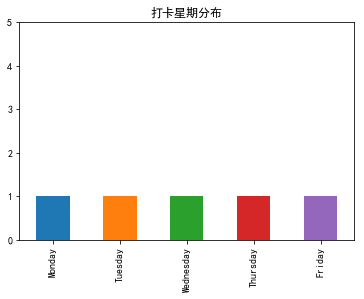

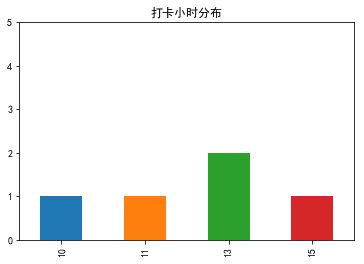

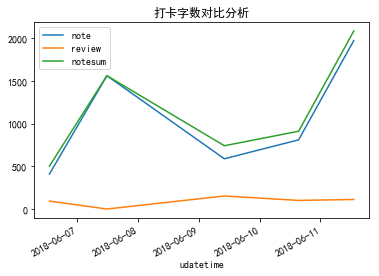

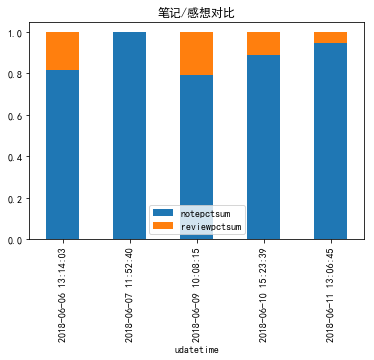

In [34]:
# filename='E:\FQM-File\PyMachine\python\PythonT410\qq2.db'
inputdir=r'E:\FQM-File\PyMachine\python\PythonT410\week7-8任务\week7-8任务\input1.txt'
filename=r'D:\PyMachine\python\PythonT410\qq2.db'
config = {'homework_tag':'#早起读书现学现卖#'}

messagerecord=message_record(inputdir) # 读取txt
qqm=savedata(filename) #建立对象
qqm.create_table() #建表
qqm.insert_notes([list(record.values()) for record in messagerecord.get_user_date_note(config)]) # 数据库

rdb=readdata(filename) #读取数据库
st=stastic(rdb.to_df()) #数据库转换为pandas表
st.static()  # 全体统计
st.reviewanlysis()  # 全体感想统计 
udb = userstastic(readdata(filename).to_df())  #个体对象
udb.useranalysis('695039978')  #个体统计